In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os
import random
from joblib import dump, load
import gzip
import msgpack
import sys
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.DataFrame()
for i in range(1, 11):
    df1 = pd.DataFrame()
    df1 = pd.read_csv(f'/content/drive/MyDrive/BTP-DataSets/MHEALTHDATASET/mHealth_subject{i}.log', header=None, sep='\t')
    df1 = df1.rename(columns={0: "acx", 1: "acy", 2: "acz", 3: "es1", 4: "es2",
                              5: "alx", 6: "aly", 7: "alz", 8: "glx", 9: "gly", 10: "glz", 11: "mlx", 12: "mly",
                              13: "mlz", 14: "arx", 15: "ary", 16: "arz", 17: "grx", 18: "gry", 19: "grz", 20: "mrx",
                              21: "mry", 22: "mrz", 23: "Activity"})
    df = pd.concat([df, df1])

<Axes: >

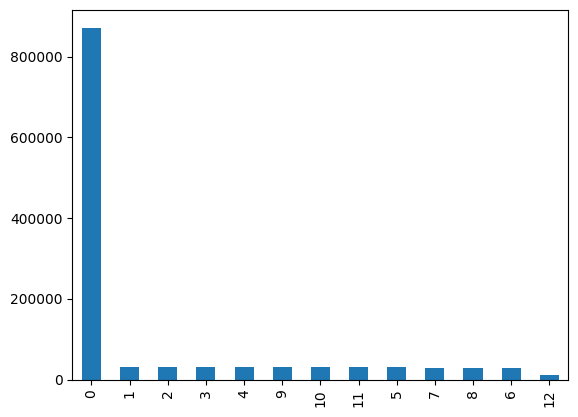

In [4]:
pd.value_counts(df['Activity']).plot.bar()

In [5]:
from sklearn.utils import resample

df_majority = df[df.Activity==0]
df_minorities = df[df.Activity!=0]

df_majority_downsampled = resample(df_majority,n_samples=30000, random_state=50)
df = pd.concat([df_majority_downsampled, df_minorities])
df.Activity.value_counts()

1     30720
2     30720
3     30720
4     30720
9     30720
10    30720
11    30720
5     30720
0     30000
7     29441
8     29337
6     28315
12    10342
Name: Activity, dtype: int64

In [6]:
num_of_clusters = 5
clusters_df=[]
for _ in range(num_of_clusters):
    clusters_df.append(df.sample(100000, replace=False))
cluster_heads=np.array([-1,-1,-1,-1,-1])

In [7]:
workers_info = []
energy_for_edge_at_start = 100000

# data, cluster no, edge score, model - coeff, model - intercept, energy consumed, acc
for i in range(5):
    for j in range(5):
        worker_data = pd.DataFrame(clusters_df[i].sample(30000, replace=False))
        worker_id = i
        worker_score = 0
        worker_coef = 0
        worker_intercept = 0
        worker_energy = []
        energy_acc = []
        energy = energy_for_edge_at_start
        workers_info.append([worker_data, worker_id, worker_coef, worker_score,
                             worker_intercept, worker_energy, energy_acc, energy])

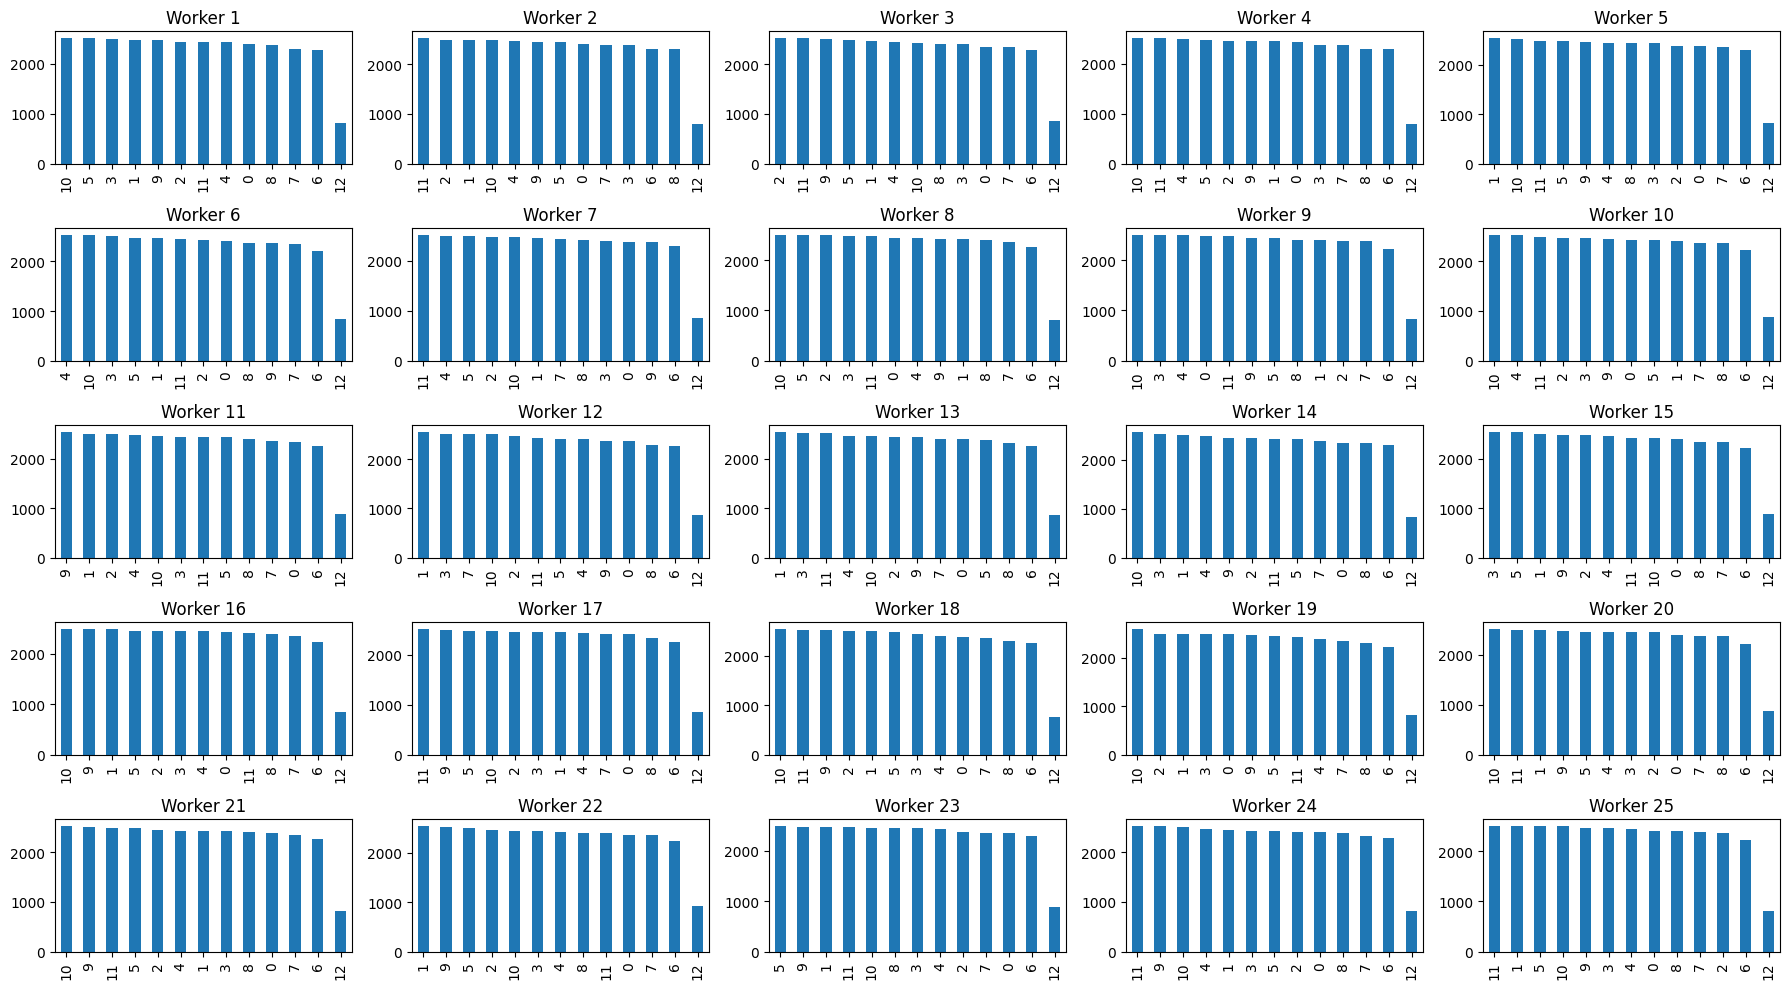

In [8]:
fig = plt.figure(figsize=(18, 10))
for i, worker in enumerate(workers_info):
    ax = fig.add_subplot(5, 5, i + 1)
    pd.value_counts(worker[0]['Activity']).plot.bar(ax=ax)
    ax.set_title(f'Worker {i + 1}')
fig.tight_layout()
plt.show()

In [9]:
import msgpack
import gzip
import io
import numpy as np
import joblib
import zlib

def extract(message):
    if message is None:
        return None, None

    try:
        # Use joblib.load to handle non-compressed models
        model = joblib.load(io.BytesIO(message))
        return model, None
    except Exception:
        pass

    try:
        # Handle gzipped models
        decompressed_byte_array = zlib.decompress(message)
        model = joblib.load(io.BytesIO(decompressed_byte_array))
        return model, None
    except Exception:
        pass

    # Return default values if extraction fails
    return None, None


def compress(model):
    try:
        # Save the model to a BytesIO object using joblib.dump
        model_bytesio = io.BytesIO()
        joblib.dump(model, model_bytesio)

        # Get the serialized model bytes
        model_bytes = model_bytesio.getvalue()

        # Compress the serialized model using gzip
        compressed_model = gzip.compress(model_bytes)

        # Store the compressed model in a MessagePack container
        message_pack_container = msgpack.packb([compressed_model])
        return message_pack_container
    except Exception:
        return None


In [22]:
max_rounds = 100  # Maximum number of training rounds
req_accuracy = 0.80  # Minimum accuracy threshold
negligible_change = 0.0001  # Change in accuracy to be considered negligible
energy_for_each_iteration=0.01
num_of_workers=25
def energy_for_transmit(data):
    power = 1  # Assuming constant power
    bandwidth = 100e6  # Bandwidth for WiFi in bits per second

    # Convert bandwidth to bytes per second
    bandwidth_bytes_per_sec = bandwidth / 8

    # Calculate time taken to transmit the given data
    time = data / bandwidth_bytes_per_sec

    # Calculate energy using the formula energy = power * time
    energy = power * time

    return energy



def terminate(accuracy, best_accuracy):
    if accuracy >= req_accuracy or abs(accuracy - best_accuracy) < negligible_change:
        return True
    return False

def local_worker_training(worker_num, global_model):
    # Shuffle the data before splitting
    workers_info[worker_num][0] = workers_info[worker_num][0].sample(frac=1, random_state=42)

    ltrain, ltest = train_test_split(workers_info[worker_num][0], test_size=0.2, random_state=42)
    lX_train = ltrain.drop('Activity', axis=1)
    ly_train = ltrain['Activity']
    lX_test = ltest.drop('Activity', axis=1)
    ly_test = ltest['Activity']

    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Initialize variables before the if-else block
    energy_consumption_in_local = 0

    if worker_num in cluster_heads and workers_info[worker_num][2] is not None:
        energy_consumption_in_local = energy_for_transmit(sys.getsizeof(workers_info[worker_num][5]) +
                                                          sys.getsizeof(workers_info[worker_num][6]))

        # If the global model coefficients are available, set them during training
        sample_weights, _ = extract(workers_info[worker_num][2])

        if sample_weights is not None:
            sample_weights = np.ones(len(lX_train)) if sample_weights.size != len(lX_train) else sample_weights
            model.fit(lX_train, ly_train, sample_weight=sample_weights)
        else:
            model.fit(lX_train, ly_train)

        if sample_weights is not None and sample_weights.size > 1 and sample_weights.shape[0] != len(lX_train):
            sample_weights = np.repeat(sample_weights, len(lX_train) // len(sample_weights) + 1)[:len(lX_train)]

    else:
        model.fit(lX_train, ly_train)

    accuracy = model.score(lX_test, ly_test)

    energy_consumption_in_local += max_rounds * energy_for_each_iteration
    workers_info[worker_num][5].append(energy_consumption_in_local)
    workers_info[worker_num][6].append(accuracy)
    workers_info[worker_num][7] -= energy_consumption_in_local

    print("local worker:", worker_num, "acc:", accuracy, "round no:", max_rounds,
          "energy remaining:", workers_info[worker_num][7])

In [11]:
def training_workers(global_model=None):
    for i in range(num_of_workers):
        local_worker_training(i, global_model)

In [12]:
def cal_batter_life(energy_rem):
    return (energy_rem / energy_for_edge_at_start) * 100


In [13]:
# Modify the cal_edge_score function
def cal_edge_score():
    w1=0.4
    w2=0.6
    for i in range(num_of_workers):
        workers_info[i][3]=w1*workers_info[i][6][-1]+w2*cal_batter_life(workers_info[i][7])


# Modify the cal_clusters_head function
def cal_clusters_head():
    for i in range(5):
        max_score_edge=i*5
        for j in range(1,5):
            if workers_info[i*5+j][3]>workers_info[max_score_edge][3]:
	            max_score_edge=i*5+j
        cluster_heads[i]=max_score_edge


In [14]:
from sklearn.ensemble import RandomForestClassifier
import copy

def global_aggregation(global_model):
    training_workers(global_model)  # Pass the global_model to training_workers
    cal_edge_score()
    cal_clusters_head()

    # Use RandomForestClassifier instead of SGDClassifier
    new_global_model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Initialize a list to store aggregated trees
    aggregated_trees = []

    num_contributing_workers = 0

    for i in range(num_of_clusters):
        worker_model, _ = extract(workers_info[i][2])  # extract returns a tuple

        if worker_model:
            # Extract the trees from the worker's RandomForestClassifier
            trees = worker_model.estimators_

            # Aggregate the trees
            if num_contributing_workers == 0:
                # If it's the first worker, simply copy the trees
                aggregated_trees = copy.deepcopy(trees)
            else:
                # Aggregate subsequent trees
                for j in range(len(aggregated_trees)):
                    aggregated_trees[j].tree_ += trees[j].tree_

            num_contributing_workers += 1

    # Normalize the aggregated trees by dividing the tree values by the number of contributing workers
    if num_contributing_workers > 0:
        for tree in aggregated_trees:
            tree.tree_ = tree.tree_ / num_contributing_workers

    # Set the aggregated trees to the new_global_model
    new_global_model.estimators_ = aggregated_trees

    return new_global_model


In [23]:
max_global_rounds = 5
acc = []
global_model = None  # Initialize global_model outside the loop

for i in range(max_global_rounds):
    global_model = global_aggregation(global_model)  # Pass the current global_model
    compressed_model = compress(global_model)

    temp_max_acc = 0
    for j in range(num_of_workers):
        # Ensure there are enough recorded accuracies for each worker
        if len(workers_info[j][6]) > i and workers_info[j][6][i] is not None:
            workers_info[j][2] = compressed_model
            temp_max_acc = max(temp_max_acc, workers_info[j][6][i])

            # Additional debugging information
            # print(f"local worker: {j} acc: {workers_info[j][6][i]} round no: {i} energy remaining: {workers_info[j][5]}")

    acc.append(temp_max_acc)
    print("round - global", i, "acc", temp_max_acc)


local worker: 0 acc: 0.95 round no: 100 energy remaining: 99994.0
local worker: 1 acc: 0.953 round no: 100 energy remaining: 99995.0
local worker: 2 acc: 0.9483333333333334 round no: 100 energy remaining: 99996.0
local worker: 3 acc: 0.9543333333333334 round no: 100 energy remaining: 99997.99998592
local worker: 4 acc: 0.951 round no: 100 energy remaining: 99998.0
local worker: 5 acc: 0.9493333333333334 round no: 100 energy remaining: 99998.0
local worker: 6 acc: 0.9523333333333334 round no: 100 energy remaining: 99998.0
local worker: 7 acc: 0.9523333333333334 round no: 100 energy remaining: 99997.99998592
local worker: 8 acc: 0.9456666666666667 round no: 100 energy remaining: 99998.0
local worker: 9 acc: 0.953 round no: 100 energy remaining: 99998.0
local worker: 10 acc: 0.954 round no: 100 energy remaining: 99998.0
local worker: 11 acc: 0.95 round no: 100 energy remaining: 99998.0
local worker: 12 acc: 0.9528333333333333 round no: 100 energy remaining: 99997.99998592
local worker: 13